Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [309]:
from random import choices

import lab9_lib

In [310]:
fitness = lab9_lib.make_problem(10)
for n in range(10):
    ind = choices([0, 1], k=50)
    print(f"{''.join(str(g) for g in ind)}: {fitness(ind):.2%}")

print(fitness.calls)

00010111101011100001001110000011110110111000010001: 7.33%
00011010001101011111110111101111000011101001110001: 23.33%
11110010011011101011100011000100100110110001101100: 15.33%
00001001111011011010001000110100110001010100000011: 7.33%
01111010110111101000010011000101110011100110000101: 9.13%
11010111000101101001000010101001100000101101101100: 15.34%
00111111001110011110101001111000011000100010010100: 23.34%
00011010011010001011000000001100010001110000101000: 7.34%
01010101110000111011110000110111111000101011111110: 7.33%
00001000001001100100110101110101100110110000010001: 11.56%
10


In [311]:
import numpy as np
import numpy.typing as npt
import networkx as nx
from typing import List, Tuple, Optional, Callable, Union
from itertools import chain, combinations
from functools import reduce
from tqdm import tqdm
from matplotlib import pyplot as plt

class Agent:

    def __init__(self, genome: Optional[np.array] = None, num_loci: int = 1000, fitness: int = 0) -> None:
        """
        num_rows: number of rows of the game
        genome: initial parameters
        k: largest number of piles it can take
        """
        if genome is None:
            self._genome = np.random.choice([0,1], num_loci)
        else:
            self._genome = genome
        
        self.fitness = fitness
        self.explicit_fitness = False
    
    def __lt__(self, other: 'Agent'):
        return self._fitness < other._fitness

    def __hash__(self):
        return hash(str(self._genome))

    def __eq__(self, other):
        if isinstance(other, Agent):
            return str(self._genome) == str(other._genome)
        return False

    @property
    def genome(self):
        return self._genome

    @genome.setter
    def genome(self, p):
        self._genome = p
    
    @property
    def fitness(self):
        return self._fitness

    @fitness.setter
    def fitness(self, fitness: float):
        self._fitness = fitness
        self.explicit_fitness = True
    
    def set_implicit_fitness(self, fitness: float):
        self._fitness = fitness
        self.explicit_fitness = False
    
    def reset(self):
        self.fitness = 0
    
    def __iadd__(self, other) -> None:
        self._genome += other


class EvolutionTask:

    def __init__(self, fitness: 'Problem', period_true_fitness: int = 5, sample_size_fitness: int = 10, novelty_factor: float = 0.01) -> None:
        self.is_island = False
        self.fitness = fitness
        self.best_fitness = 0
        self.fitness_list = []
        self.similarity_matrix = None
        self.set_fitness_calculation_params(period_true_fitness, sample_size_fitness, novelty_factor)
    
    def set_fitness_calculation_params(self, period_true_fitness: int = 5, sample_size_fitness: int = 10, novelty_factor: float = 1) -> None:
        self.period_true_fitness = period_true_fitness
        self.sample_size_fitness = sample_size_fitness
        self.novelty_factor = novelty_factor
    
    def mutate(self, agent: Agent, p: float = 0.001) -> Agent:
        """
        Mutates loci with random flipping and returns a new agent
        """
        new_genome = []
        for locus in agent.genome:
            if np.random.rand()<p:
                new_genome.append(1-locus)
            else:
                new_genome.append(locus)
        return Agent(np.array(new_genome), np.random.normal(agent.fitness, scale=self.novelty_factor/(1+agent.fitness)))

    def calculate_fitness(self, explicit: bool=True) -> None:
        """
        Calculates the fitness of the current population
        """
        if explicit:
            best_in_gen = 0
            for agent in self.agents:
                agent.fitness = self.fitness(agent.genome)
                if agent.fitness > best_in_gen:
                    best_in_gen = agent.fitness
            self.fitness_list.append(best_in_gen)
        else:
            self.fitness_list.append(self.fitness_list[-1])

    
    def crossover(self, a1: Agent, a2: Agent, a: float=1, b: float=999) -> Agent:
        """
        Given two agents it randomly selects the parameters between the two
        """
        n = int(np.random.beta(a,b)*len(a1.genome))
        new_genome = np.concatenate((a1.genome[0:n], a2.genome[n:]))
        avg_fitness = (a1.fitness+a2.fitness)/2
        return Agent(new_genome, fitness=np.random.normal(avg_fitness, scale=self.novelty_factor/(1+avg_fitness)))
    
    def es_iter(self, agents: Optional['np.array']=None, population_size: int=100, mu: int=30, strategy='comma', p=0.001) -> None:
        
        if agents is None:
            self.agents = np.partition(self.agents, population_size-mu)[population_size-mu:] # selective pressure, takes top mu agents
        else:
            self.agents = agents

        if strategy == 'comma':
            num_children = population_size
        else:
            num_children = population_size-mu
        
        parents = np.random.choice(self.agents, num_children)
        children = np.array([self.mutate(a, p) for a in parents])
        if strategy == 'comma':
            self.agents = children
        else:
            self.agents = np.concatenate((children, self.agents))
    
    def ga_iter(self, agents: Optional['np.array']=None, population_size: int=100, mu: int=30, strategy='comma', p=0.001, a_beta=1, b_beta=999) -> None:
        
        if agents is None:
            self.agents = np.partition(self.agents, population_size-mu)[population_size-mu:] # selective pressure, takes top mu agents
        else:
            self.agents = agents


        if strategy == 'comma':
            num_children = population_size
        else:
            num_children = population_size-mu
        
        
        parents = np.random.choice(self.agents, num_children)
        children = [self.crossover(a[0], a[1], a_beta, b_beta) for a in np.random.choice(parents, (num_children, 2))]
        children = np.array([self.mutate(a, p) for a in children])
        if strategy == 'comma':
            self.agents = children
        else:
            self.agents = np.concatenate((children, self.agents))
    
    def es(self, n_generations: int=100, population_size: int=100, mu: int=30, strategy='comma', p=0.001) -> None:
        self.is_island = False
        self.agents: 'np.array' = np.array([Agent() for _ in range(population_size)])
        for gen in tqdm(range(n_generations)):
            self.calculate_fitness(explicit=gen%self.period_true_fitness==0)
            self.es_iter(population_size=population_size, mu=mu, strategy=strategy, p=p)
        self.calculate_fitness()
    
    def genetic_algorithm(self, n_generations: int=100, population_size: int=100, mu: int=30, strategy='comma', p=0.001, a_beta=1, b_beta=999) -> None:
        self.is_island = False
        self.agents: 'np.array' = np.array([Agent() for _ in range(population_size)])
        flatness_factor = 1
        for gen in tqdm(range(n_generations)):
            self.calculate_fitness(explicit=gen%self.period_true_fitness==0)
            if gen > n_generations//10:
                flatness_factor = np.var(self.fitness_list[gen-n_generations//10:])+1e-3
            self.ga_iter(population_size=population_size, mu=mu, strategy=strategy, p=min(0.5,p/flatness_factor), a_beta=a_beta, b_beta=b_beta)
        self.calculate_fitness()
    
    def migrate(self, migration_size: int=1, hierarchical: bool=False) -> 'np.array':
        if hierarchical:
            population_size = len(self.agents)
            # migrants = np.partition(self.agents, population_size-migration_size)[population_size-migration_size:], np.partition(self.agents, migration_size)[:migration_size]
            migrants_indeces = np.concatenate([np.argpartition(self.agents, population_size-migration_size)[population_size-migration_size:], np.argpartition(self.agents, migration_size)[:migration_size]])
            best_indeces, worse_indeces = np.argpartition(self.agents, population_size-migration_size)[population_size-migration_size:], np.argpartition(self.agents, migration_size)[:migration_size]
            best_migrants = self.agents[best_indeces]
            worse_migrants = self.agents[worse_indeces]
            migrants = best_migrants, worse_migrants
            self.agents = self.agents[np.in1d(np.arange(len(self.agents)), np.concatenate([best_indeces, worse_indeces]), invert=True)]
        else:
            migrants_indeces = np.random.choice(np.arange(len(self.agents)), migration_size, replace=False)
            migrants = self.agents[migrants_indeces]
            self.agents = self.agents[np.in1d(np.arange(len(self.agents)), migrants_indeces, invert=True)]

        return migrants
    
    def receive_migrants(self, migrants: 'np.array'):
        self.agents = np.concatenate((self.agents, migrants))
    
    def island_model(self, n_generations: int=100, migration_period: int=1, migration_size: int=1, island_size: int=10, n_islands: int = 10, mu_island: int=3, strategy='comma', p=0.001, a_beta=1, b_beta=999, replace=False, hierarchical=False, mode='ga'):
        self.is_island = True
        self.islands: 'np.array' = [EvolutionTask(self.fitness, period_true_fitness=self.period_true_fitness) for _ in range(n_islands)]
        flatness_factor = 1
        for i in tqdm(range(n_generations)):
            if i > n_generations//10:
                flatness_factor = np.var(self.fitness_list[i-n_generations//10:])+1e-3
            for island in self.islands:
                if i == 0:
                    island.agents=np.array([Agent() for _ in range(island_size)])
                    if mode=='ga':
                        island.ga_iter(population_size=island_size, mu=mu_island, strategy=strategy, p=p, a_beta=a_beta, b_beta=b_beta)
                    else:
                        island.es_iter(population_size=island_size, mu=mu_island, strategy=strategy, p=p)
                else:
                    if mode=='ga':
                        island.ga_iter(population_size=island_size, mu=mu_island, strategy=strategy, p=p/flatness_factor, a_beta=a_beta, b_beta=b_beta)
                    else:
                        island.es_iter(population_size=island_size, mu=mu_island, strategy=strategy, p=p)
            if i%migration_period==0:
                if hierarchical:
                    for j, island in enumerate(self.islands):
                        best, worse = island.migrate(migration_size, hierarchical)
                        if j==0:
                            previous_worse = worse
                            previous_island = island
                            island.receive_migrants(best)
                        elif j==len(self.islands)-1:
                            island.receive_migrants(previous_worse)
                            island.receive_migrants(worse)
                            previous_island.receive_migrants(best)
                        else:
                            island.receive_migrants(previous_worse)
                            previous_island.receive_migrants(best)
                            previous_island=island
                else:
                    migrants = np.concatenate([island.migrate(migration_size) for island in self.islands])
                    migrants = np.random.choice(migrants, size=(n_islands, migration_size), replace=replace)
                    for j, island in enumerate(self.islands):
                        island.receive_migrants(migrants[j,:])
            for island in self.islands:
                if len(island.agents) != island_size:
                    raise UserWarning(f'Bug in code, wrong island size: {len(island.agents)} != {island_size}')
                island.calculate_fitness(explicit=i%self.period_true_fitness==0)
        for island in self.islands:
            island.calculate_fitness()
    
    def plot_fitness(self) -> None:
        if self.is_island:
            best_island_idx = np.argmax([isle.best_fitness for isle in self.islands])
            self.islands[best_island_idx].plot_fitness()
        plt.plot(self.fitness_list)
    
    @property
    def best_fitness(self) -> float:
        if self.is_island:
            return max([island.best_fitness for island in self.islands])
        return max(self.fitness_list)
    
    @best_fitness.setter
    def best_fitness(self, f) -> None:
        self._best_fitness = f
    
    @property
    def fitness_calls(self) -> int:
        return self.fitness.calls

In [312]:
fitness = lab9_lib.make_problem(5)
et = EvolutionTask(fitness, period_true_fitness=1)
et.es(n_generations=1000, mu=30, population_size=100, strategy='plus')
et.plot_fitness()
print(et.best_fitness, fitness.calls)

  0%|          | 0/1000 [00:00<?, ?it/s]

  4%|▍         | 44/1000 [00:04<01:32, 10.29it/s]


KeyboardInterrupt: 

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:21<00:00,  1.22it/s]


0.586 101000


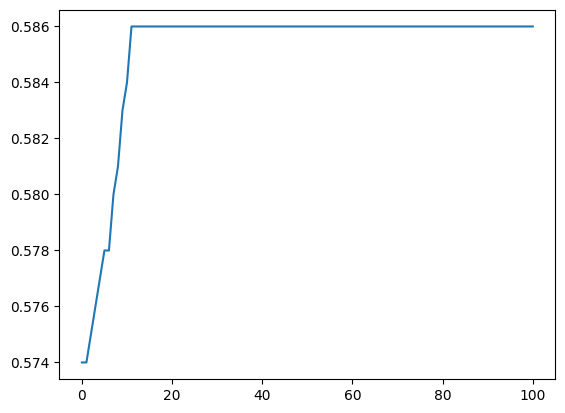

In [ ]:
fitness = lab9_lib.make_problem(1)
et = EvolutionTask(fitness, period_true_fitness=1)
et.genetic_algorithm(n_generations=100, mu=30, population_size=1000, strategy='plus')
et.plot_fitness()
print(et.best_fitness, fitness.calls)

100%|██████████| 2000/2000 [08:04<00:00,  4.13it/s]


0.97 600300


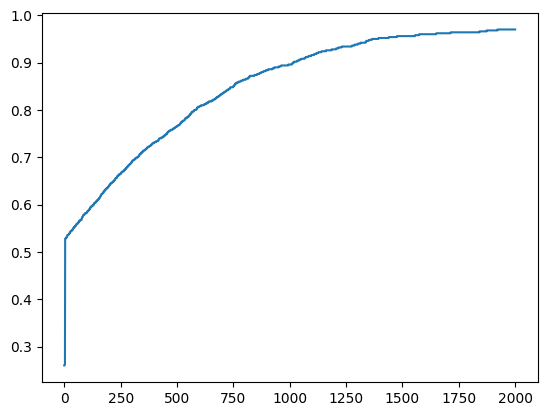

In [319]:
fitness = lab9_lib.make_problem(2)
et = EvolutionTask(fitness, period_true_fitness=1)
et.island_model(n_generations=2000, n_islands=3, mu_island=30, migration_size=10, island_size=100, strategy='plus', hierarchical=True, migration_period=2, mode='es')
et.plot_fitness()
print(et.best_fitness, fitness.calls)